# 01 — BraTS 2021 Data Quality Control

Comprehensive QC: dataset overview, spacing/shape checks, intensity distributions, label statistics, sample visualizations.

In [1]:
import os
import numpy as np
import nibabel as nib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import defaultdict
from tqdm import tqdm

DATA_ROOT = Path('/Users/xuqian/Documents/GitHub/DataChallenge/BraTS/data/BraTS2021_Training_Data')
OUT_DIR = Path('/Users/xuqian/Documents/GitHub/DataChallenge/BraTS/outputs/qc')
OUT_DIR.mkdir(parents=True, exist_ok=True)

MODALITIES = ['flair', 't1', 't1ce', 't2']

subjects = sorted([d.name for d in DATA_ROOT.iterdir() if d.is_dir() and d.name.startswith('BraTS2021_')])
print(f'Total subjects: {len(subjects)}')
print(f'First 5: {subjects[:5]}')
print(f'Last  5: {subjects[-5:]}')

Total subjects: 10
First 5: ['BraTS2021_00000', 'BraTS2021_00001', 'BraTS2021_00002', 'BraTS2021_00003', 'BraTS2021_00004']
Last  5: ['BraTS2021_00005', 'BraTS2021_00006', 'BraTS2021_00007', 'BraTS2021_00008', 'BraTS2021_00009']


## 1. File Completeness Check

In [2]:
# Check every subject has all expected files
expected_suffixes = MODALITIES + ['seg']
missing = []

for sid in tqdm(subjects, desc='Checking files'):
    for mod in expected_suffixes:
        fpath = DATA_ROOT / sid / f'{sid}_{mod}.nii.gz'
        if not fpath.exists():
            missing.append((sid, mod))

if missing:
    print(f'WARNING: {len(missing)} missing files:')
    for sid, mod in missing[:10]:
        print(f'  {sid} / {mod}')
else:
    print(f'All {len(subjects)} subjects have complete files (4 modalities + seg).')

Checking files:   0%|          | 0/10 [00:00<?, ?it/s]

Checking files: 100%|██████████| 10/10 [00:00<00:00, 5467.74it/s]

All 10 subjects have complete files (4 modalities + seg).


## 2. Shape & Spacing Statistics

In [3]:
# Collect metadata from all subjects (sample flair for shape/spacing)
records = []
for sid in tqdm(subjects, desc='Reading headers'):
    nii = nib.load(str(DATA_ROOT / sid / f'{sid}_flair.nii.gz'))
    shape = nii.shape
    spacing = tuple(np.round(nii.header.get_zooms()[:3], 4))
    records.append({
        'subject': sid,
        'x': shape[0], 'y': shape[1], 'z': shape[2],
        'sx': spacing[0], 'sy': spacing[1], 'sz': spacing[2]
    })

df_meta = pd.DataFrame(records)
print('=== Shape distribution ===')
print(df_meta[['x', 'y', 'z']].describe().round(2))
print(f'\nUnique shapes: {df_meta[["x","y","z"]].drop_duplicates().shape[0]}')
print(df_meta[['x','y','z']].drop_duplicates())

print('\n=== Spacing distribution ===')
print(df_meta[['sx', 'sy', 'sz']].describe().round(4))
print(f'\nUnique spacings: {df_meta[["sx","sy","sz"]].drop_duplicates().shape[0]}')
print(df_meta[['sx','sy','sz']].drop_duplicates())

Reading headers:   0%|          | 0/10 [00:00<?, ?it/s]

Reading headers: 100%|██████████| 10/10 [00:00<00:00, 1636.67it/s]

=== Shape distribution ===
           x      y     z
count   10.0   10.0  10.0
mean   128.0  128.0  80.0
std      0.0    0.0   0.0
min    128.0  128.0  80.0
25%    128.0  128.0  80.0
50%    128.0  128.0  80.0
75%    128.0  128.0  80.0
max    128.0  128.0  80.0

Unique shapes: 1
     x    y   z
0  128  128  80

=== Spacing distribution ===
         sx    sy    sz
count  10.0  10.0  10.0
mean    1.0   1.0   1.0
std     0.0   0.0   0.0
min     1.0   1.0   1.0
25%     1.0   1.0   1.0
50%     1.0   1.0   1.0
75%     1.0   1.0   1.0
max     1.0   1.0   1.0

Unique spacings: 1
    sx   sy   sz
0  1.0  1.0  1.0


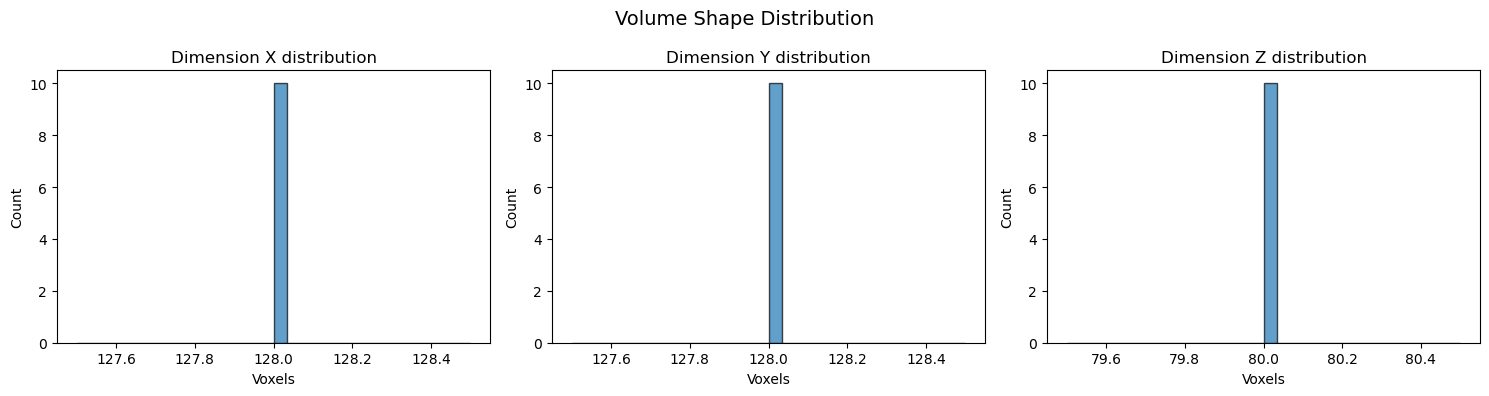

In [4]:
# Plot shape and spacing distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, dim in enumerate(['x', 'y', 'z']):
    axes[i].hist(df_meta[dim], bins=30, edgecolor='black', alpha=0.7)
    axes[i].set_title(f'Dimension {dim.upper()} distribution')
    axes[i].set_xlabel('Voxels')
    axes[i].set_ylabel('Count')
plt.suptitle('Volume Shape Distribution', fontsize=14)
plt.tight_layout()
plt.savefig(str(OUT_DIR / 'shape_distribution.png'), dpi=150, bbox_inches='tight')
plt.show()

## 3. Intensity Distributions (sampled)

In [5]:
# Sample 50 subjects for intensity stats
np.random.seed(42)
sample_ids = np.random.choice(subjects, size=min(50, len(subjects)), replace=False)

intensity_stats = defaultdict(list)

for sid in tqdm(sample_ids, desc='Intensity stats'):
    for mod in MODALITIES:
        data = nib.load(str(DATA_ROOT / sid / f'{sid}_{mod}.nii.gz')).get_fdata()
        brain = data[data > 0]  # non-zero voxels only
        if len(brain) > 0:
            intensity_stats[mod].append({
                'subject': sid,
                'mean': brain.mean(),
                'std': brain.std(),
                'min': brain.min(),
                'max': brain.max(),
                'p01': np.percentile(brain, 1),
                'p99': np.percentile(brain, 99)
            })

for mod in MODALITIES:
    df_int = pd.DataFrame(intensity_stats[mod])
    print(f'\n=== {mod.upper()} intensity (non-zero, n={len(df_int)}) ===')
    print(df_int[['mean', 'std', 'min', 'max', 'p01', 'p99']].describe().round(2))

Intensity stats:   0%|          | 0/10 [00:00<?, ?it/s]

Intensity stats:  10%|█         | 1/10 [00:00<00:01,  7.81it/s]

Intensity stats:  20%|██        | 2/10 [00:00<00:01,  7.76it/s]

Intensity stats:  30%|███       | 3/10 [00:00<00:00,  7.66it/s]

Intensity stats:  40%|████      | 4/10 [00:00<00:00,  7.89it/s]

Intensity stats:  50%|█████     | 5/10 [00:00<00:00,  7.80it/s]

Intensity stats:  60%|██████    | 6/10 [00:00<00:00,  7.83it/s]

Intensity stats:  70%|███████   | 7/10 [00:00<00:00,  7.69it/s]

Intensity stats:  80%|████████  | 8/10 [00:01<00:00,  7.58it/s]

Intensity stats:  90%|█████████ | 9/10 [00:01<00:00,  7.52it/s]

Intensity stats: 100%|██████████| 10/10 [00:01<00:00,  7.47it/s]

Intensity stats: 100%|██████████| 10/10 [00:01<00:00,  7.63it/s]


=== FLAIR intensity (non-zero, n=10) ===
         mean     std   min     max    p01     p99
count   10.00   10.00  10.0   10.00  10.00   10.00
mean   302.02  211.42   0.0  814.03   1.05  598.96
std      2.28    1.97   0.0    9.61   0.02   14.69
min    298.23  207.48   0.0  802.67   1.01  559.90
25%    300.13  210.26   0.0  806.90   1.04  598.33
50%    302.50  211.55   0.0  811.63   1.06  604.25
75%    303.51  213.02   0.0  821.36   1.07  606.42
max    305.72  213.72   0.0  831.11   1.07  609.57

=== T1 intensity (non-zero, n=10) ===
         mean     std   min     max    p01     p99
count   10.00   10.00  10.0   10.00  10.00   10.00
mean   266.43  183.59   0.0  577.62   1.05  472.55
std      2.06    0.85   0.0   12.68   0.02    2.15
min    262.80  182.27   0.0  551.84   1.01  467.88
25%    265.16  183.05   0.0  571.76   1.03  471.73
50%    267.33  183.44   0.0  579.78   1.04  473.15
75%    267.71  184.27   0.0  584.93   1.06  473.83
max    269.09  184.92   0.0  593.28   1.08  474.85



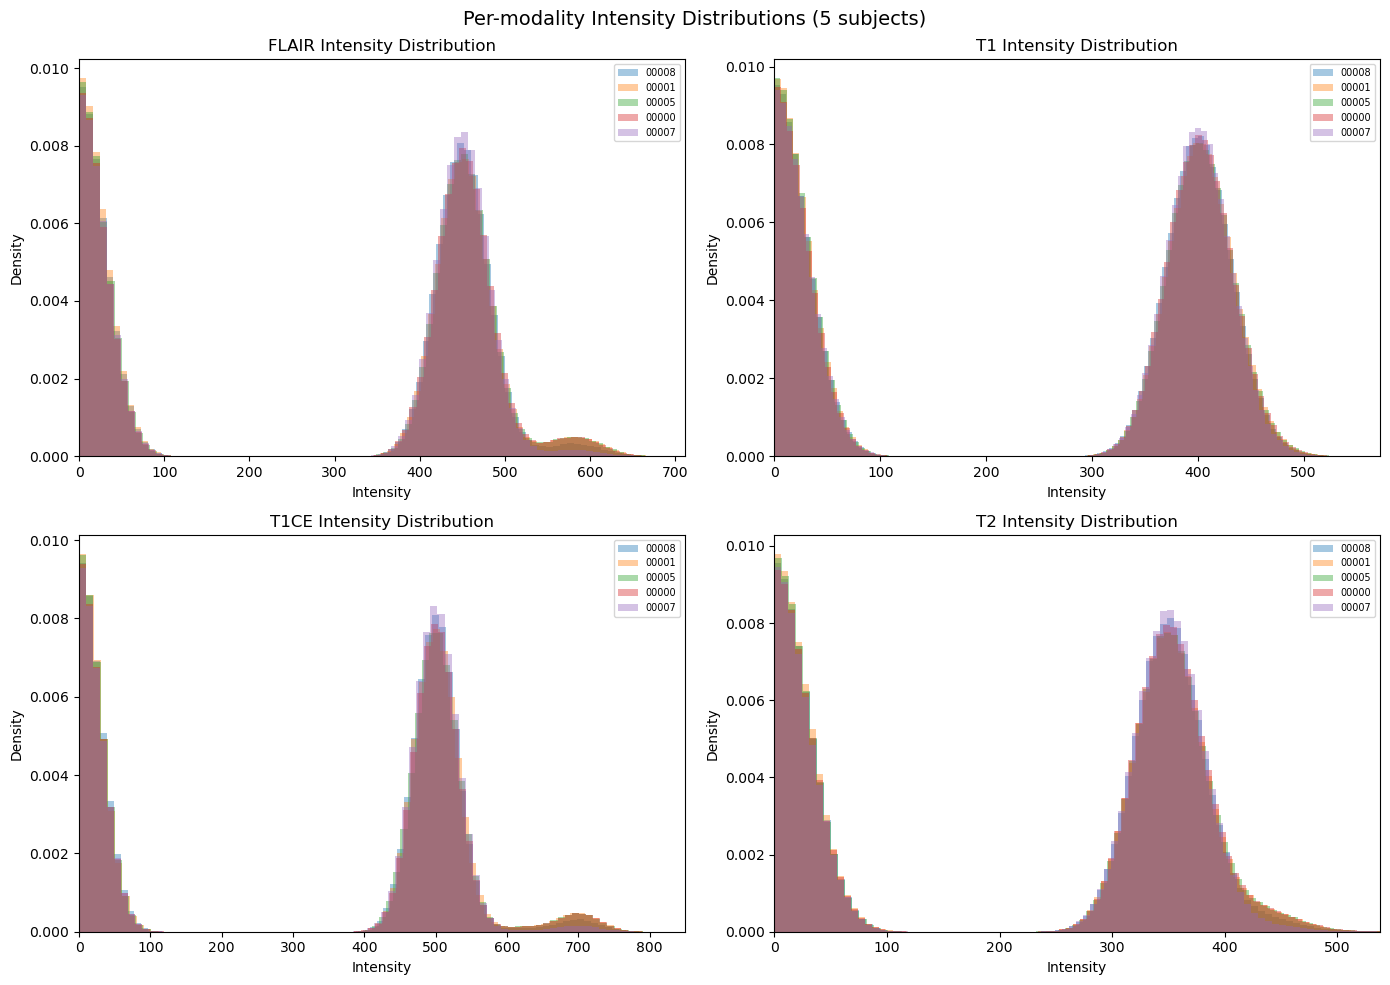

In [6]:
# Plot intensity distributions for 5 random subjects
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
plot_ids = sample_ids[:5]

for ax, mod in zip(axes.flat, MODALITIES):
    for sid in plot_ids:
        data = nib.load(str(DATA_ROOT / sid / f'{sid}_{mod}.nii.gz')).get_fdata()
        brain = data[data > 0]
        ax.hist(brain, bins=100, alpha=0.4, density=True, label=sid[-5:])
    ax.set_title(f'{mod.upper()} Intensity Distribution')
    ax.set_xlabel('Intensity')
    ax.set_ylabel('Density')
    ax.legend(fontsize=7)
    ax.set_xlim(0, np.percentile(brain, 99.5) * 1.2)

plt.suptitle('Per-modality Intensity Distributions (5 subjects)', fontsize=14)
plt.tight_layout()
plt.savefig(str(OUT_DIR / 'intensity_distributions.png'), dpi=150, bbox_inches='tight')
plt.show()

## 4. Label / Segmentation Statistics

In [7]:
# Collect label stats for all subjects
label_records = []
LABEL_NAMES = {0: 'Background', 1: 'NCR/NET', 2: 'ED', 4: 'ET'}

for sid in tqdm(subjects, desc='Label stats'):
    seg = nib.load(str(DATA_ROOT / sid / f'{sid}_seg.nii.gz')).get_fdata().astype(int)
    unique_labels = set(np.unique(seg))
    total_voxels = seg.size
    rec = {'subject': sid, 'unique_labels': str(sorted(unique_labels))}
    for lbl, name in LABEL_NAMES.items():
        count = int(np.sum(seg == lbl))
        rec[f'{name}_count'] = count
        rec[f'{name}_pct'] = round(100.0 * count / total_voxels, 4)
    # Whole tumor = 1 + 2 + 4
    rec['WT_count'] = rec['NCR/NET_count'] + rec['ED_count'] + rec['ET_count']
    rec['WT_pct'] = round(rec['NCR/NET_pct'] + rec['ED_pct'] + rec['ET_pct'], 4)
    label_records.append(rec)

df_labels = pd.DataFrame(label_records)
print('=== Label volume statistics (% of total volume) ===')
pct_cols = [c for c in df_labels.columns if c.endswith('_pct')]
print(df_labels[pct_cols].describe().round(4))

print(f'\n=== Unique label sets ===')
print(df_labels['unique_labels'].value_counts())

Label stats:   0%|          | 0/10 [00:00<?, ?it/s]

Label stats: 100%|██████████| 10/10 [00:00<00:00, 129.77it/s]

=== Label volume statistics (% of total volume) ===
       Background_pct  NCR/NET_pct   ED_pct   ET_pct   WT_pct
count         10.0000      10.0000  10.0000  10.0000  10.0000
mean          97.0812       0.5564   2.2838   0.0786   2.9188
std            0.8643       0.1695   0.6717   0.0233   0.8643
min           96.1294       0.1968   0.8414   0.0297   1.0679
25%           96.6129       0.4752   2.0026   0.0683   2.5461
50%           96.8324       0.6074   2.4749   0.0852   3.1675
75%           97.4540       0.6529   2.6416   0.0925   3.3870
max           98.9321       0.7408   3.0263   0.1035   3.8706

=== Unique label sets ===
unique_labels
[np.int64(0), np.int64(1), np.int64(2), np.int64(4)]    10
Name: count, dtype: int64


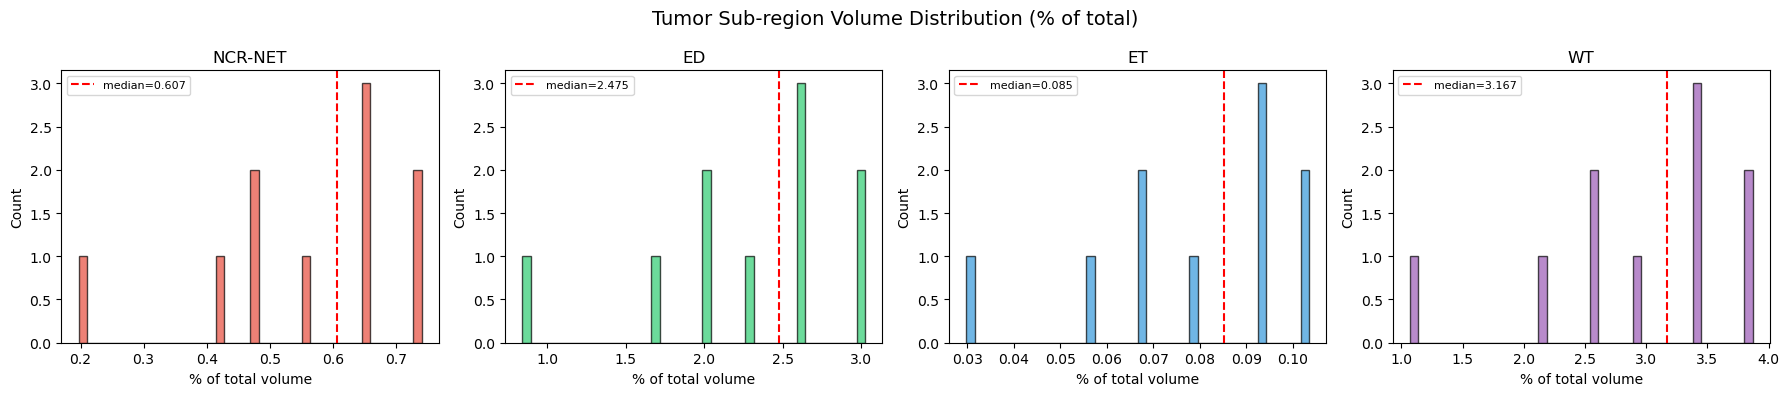

In [8]:
# Plot tumor volume distributions
fig, axes = plt.subplots(1, 4, figsize=(18, 4))
tumor_cols = ['NCR/NET_pct', 'ED_pct', 'ET_pct', 'WT_pct']
colors = ['#e74c3c', '#2ecc71', '#3498db', '#9b59b6']

for ax, col, color in zip(axes, tumor_cols, colors):
    ax.hist(df_labels[col], bins=40, edgecolor='black', alpha=0.7, color=color)
    ax.set_title(col.replace('_pct', '').replace('/', '-'))
    ax.set_xlabel('% of total volume')
    ax.set_ylabel('Count')
    ax.axvline(df_labels[col].median(), color='red', linestyle='--', label=f'median={df_labels[col].median():.3f}')
    ax.legend(fontsize=8)

plt.suptitle('Tumor Sub-region Volume Distribution (% of total)', fontsize=14)
plt.tight_layout()
plt.savefig(str(OUT_DIR / 'label_distributions.png'), dpi=150, bbox_inches='tight')
plt.show()

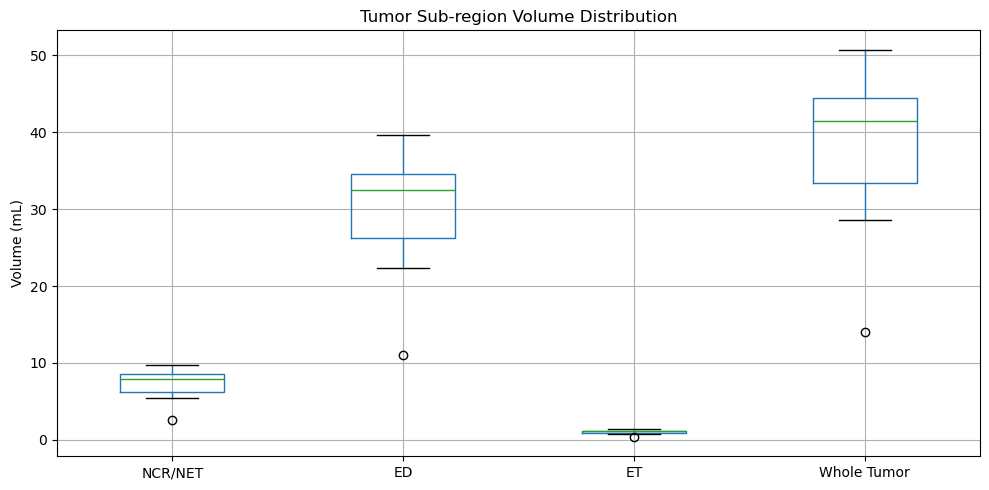

In [9]:
# Box plot of tumor volumes
fig, ax = plt.subplots(figsize=(10, 5))
count_cols = ['NCR/NET_count', 'ED_count', 'ET_count', 'WT_count']
plot_data = df_labels[count_cols].copy()
plot_data.columns = ['NCR/NET', 'ED', 'ET', 'Whole Tumor']
# Convert to mL (1mm^3 voxels -> 1mm^3 = 0.001 mL)
plot_data_ml = plot_data * 0.001  # assuming 1mm isotropic
plot_data_ml.boxplot(ax=ax)
ax.set_ylabel('Volume (mL)')
ax.set_title('Tumor Sub-region Volume Distribution')
plt.tight_layout()
plt.savefig(str(OUT_DIR / 'tumor_volume_boxplot.png'), dpi=150, bbox_inches='tight')
plt.show()

## 5. Sample Visualization (6 random subjects)

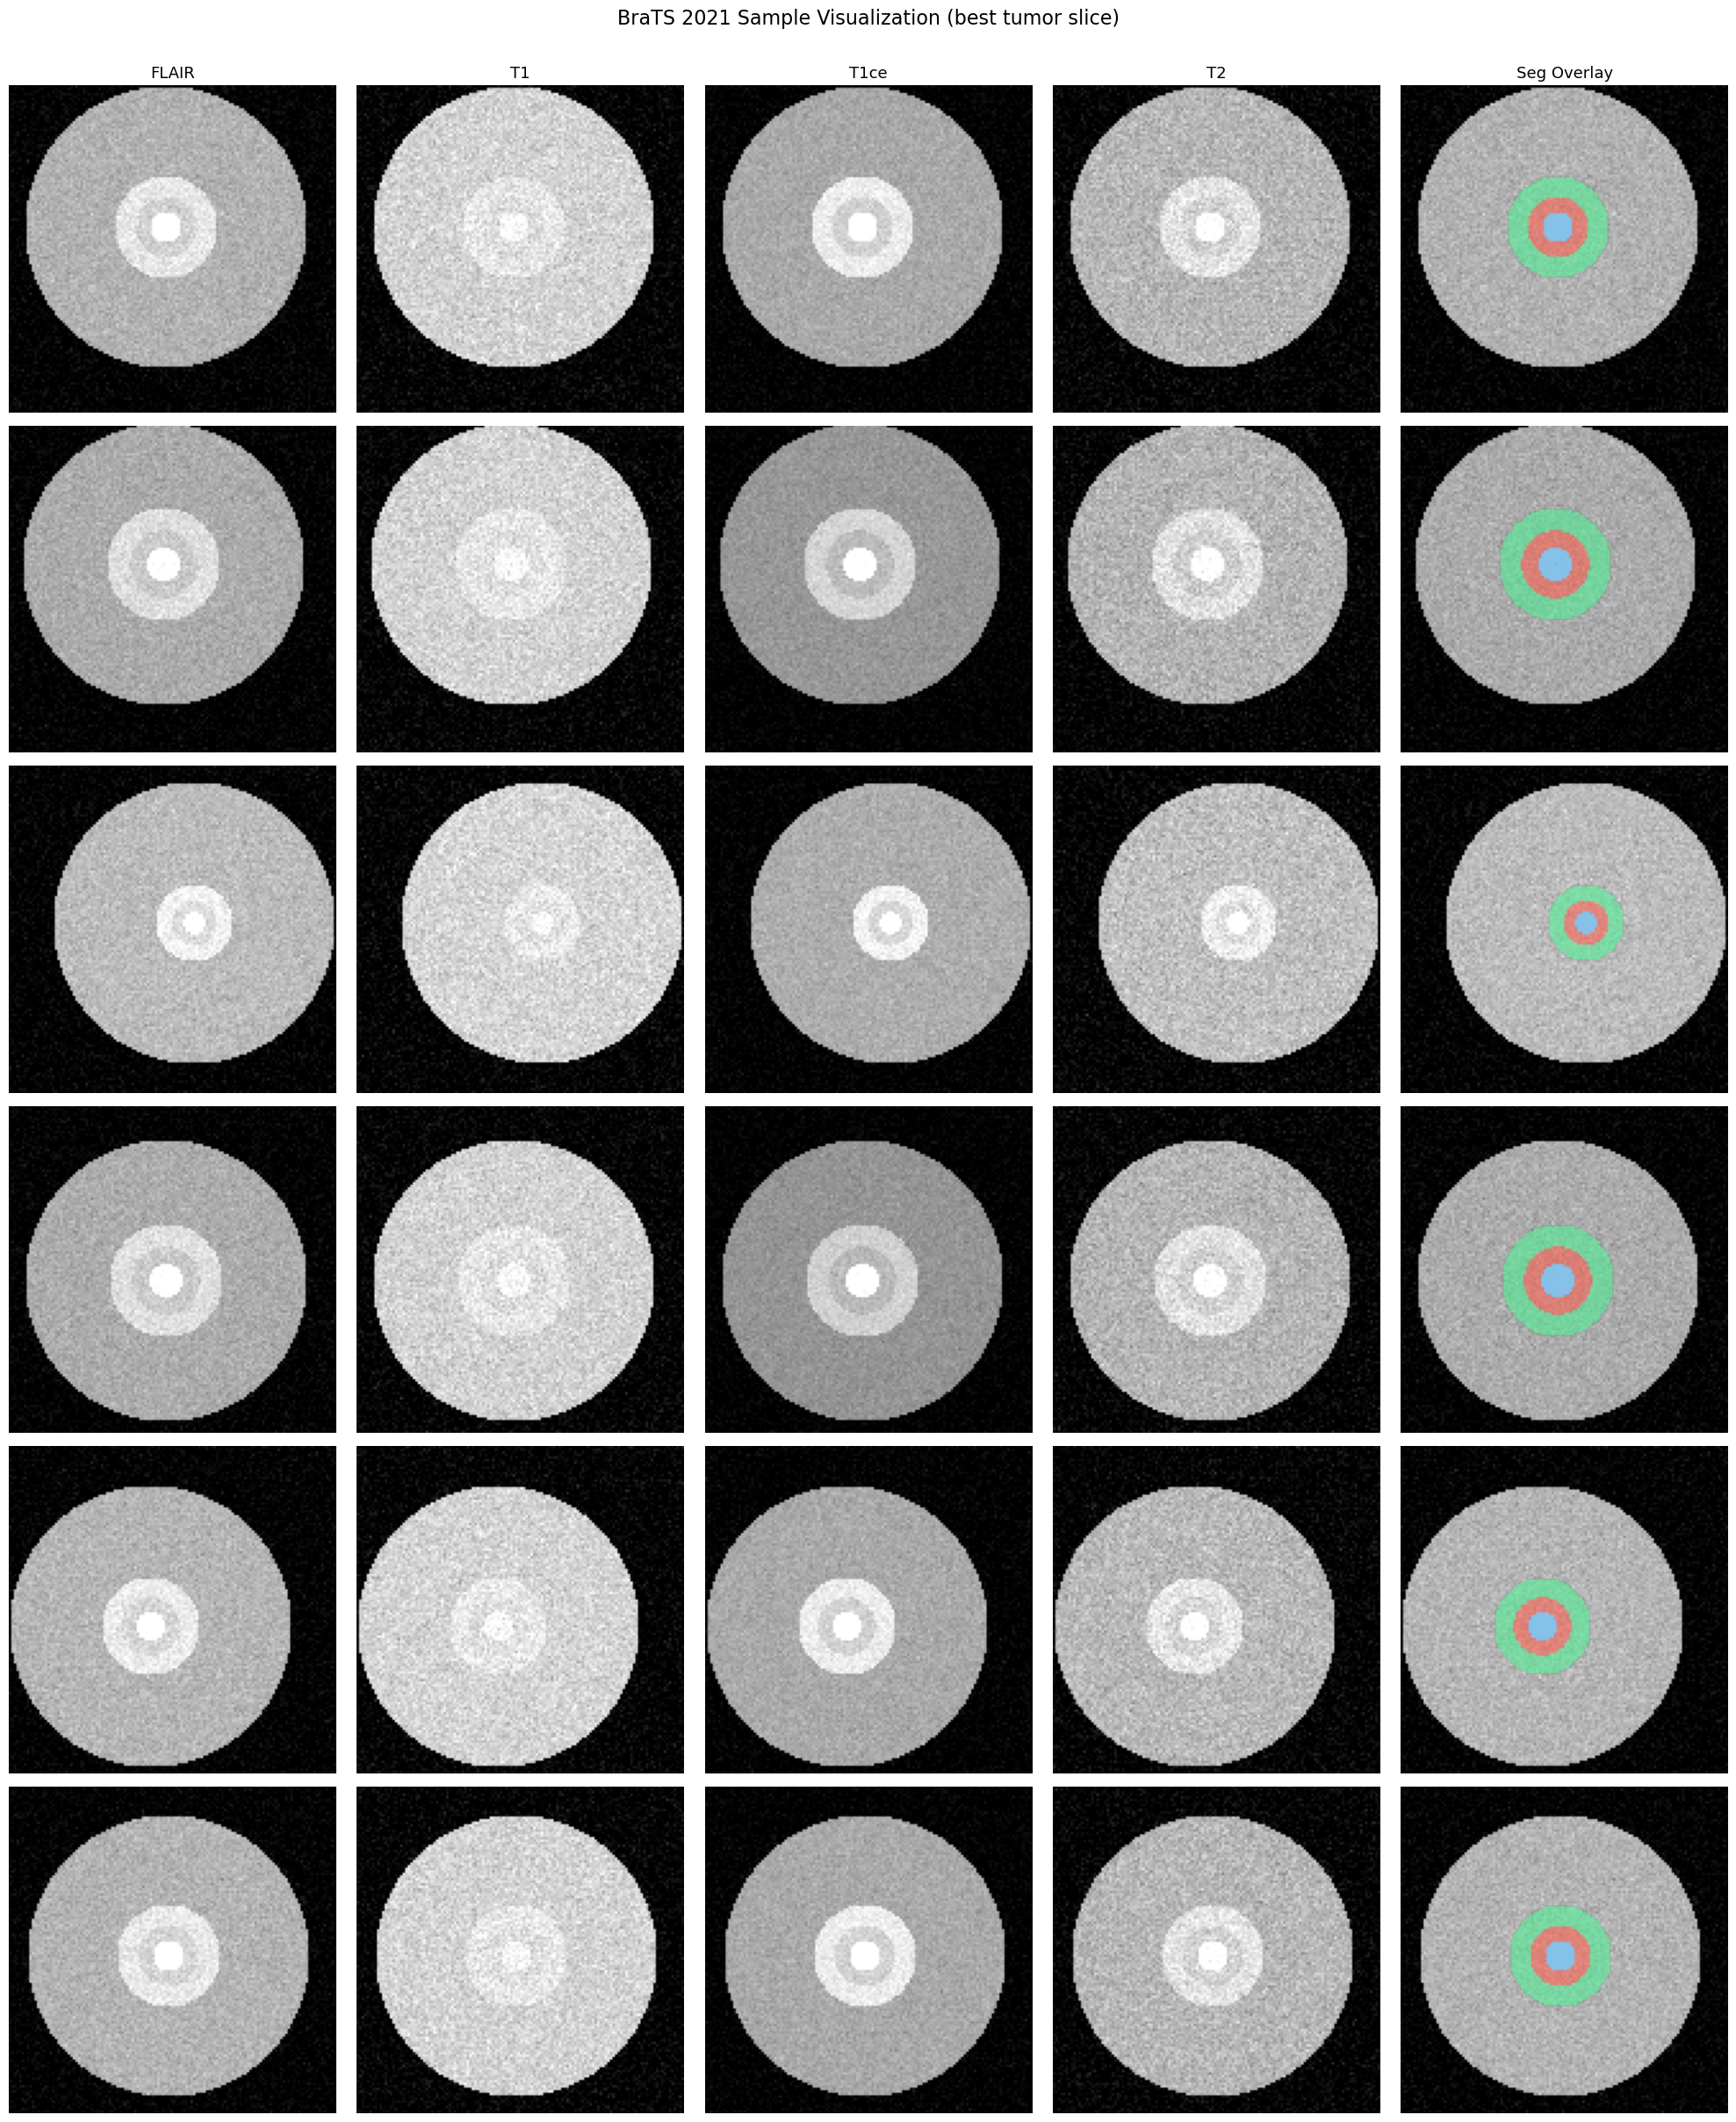

Figure saved.


In [10]:
# Show 6 random subjects: all 4 modalities + seg overlay
np.random.seed(123)
vis_ids = np.random.choice(subjects, size=6, replace=False)

fig, axes = plt.subplots(6, 5, figsize=(20, 24))
col_titles = ['FLAIR', 'T1', 'T1ce', 'T2', 'Seg Overlay']

# Colormap for segmentation
from matplotlib.colors import ListedColormap
seg_cmap = ListedColormap(['none', '#e74c3c', '#2ecc71', 'none', '#3498db'])

for i, sid in enumerate(vis_ids):
    volumes = {}
    for mod in MODALITIES:
        volumes[mod] = nib.load(str(DATA_ROOT / sid / f'{sid}_{mod}.nii.gz')).get_fdata()
    seg = nib.load(str(DATA_ROOT / sid / f'{sid}_seg.nii.gz')).get_fdata().astype(int)
    
    # Find slice with most tumor
    tumor_per_slice = np.sum(seg > 0, axis=(0, 1))
    best_slice = np.argmax(tumor_per_slice)
    
    for j, mod in enumerate(MODALITIES):
        sl = volumes[mod][:, :, best_slice]
        vmax = np.percentile(sl[sl > 0], 99) if sl.max() > 0 else 1
        axes[i, j].imshow(sl.T, cmap='gray', origin='lower', vmin=0, vmax=vmax)
        axes[i, j].axis('off')
        if i == 0:
            axes[i, j].set_title(col_titles[j], fontsize=13)
    
    # Seg overlay on FLAIR
    flair_sl = volumes['flair'][:, :, best_slice]
    seg_sl = seg[:, :, best_slice]
    vmax = np.percentile(flair_sl[flair_sl > 0], 99) if flair_sl.max() > 0 else 1
    axes[i, 4].imshow(flair_sl.T, cmap='gray', origin='lower', vmin=0, vmax=vmax)
    masked_seg = np.ma.masked_where(seg_sl == 0, seg_sl)
    axes[i, 4].imshow(masked_seg.T, cmap=seg_cmap, origin='lower', alpha=0.6, vmin=0, vmax=4)
    axes[i, 4].axis('off')
    if i == 0:
        axes[i, 4].set_title(col_titles[4], fontsize=13)
    
    axes[i, 0].set_ylabel(sid[-5:], fontsize=11, rotation=0, labelpad=50)

plt.suptitle('BraTS 2021 Sample Visualization (best tumor slice)', fontsize=16, y=1.005)
plt.tight_layout()
plt.savefig(str(OUT_DIR / 'sample_visualization.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Figure saved.')

## 6. QC Summary

In [11]:
# Save metadata to CSV
df_meta.to_csv(str(OUT_DIR / 'metadata.csv'), index=False)
df_labels.to_csv(str(OUT_DIR / 'label_stats.csv'), index=False)

print('=== QC Summary ===')
print(f'Total subjects:     {len(subjects)}')
print(f'Missing files:      {len(missing)}')
print(f'Unique shapes:      {df_meta[["x","y","z"]].drop_duplicates().shape[0]}')
print(f'Unique spacings:    {df_meta[["sx","sy","sz"]].drop_duplicates().shape[0]}')
print(f'Mean WT volume %:   {df_labels["WT_pct"].mean():.4f}')
print(f'\nSaved CSVs and figures to: {OUT_DIR}')
print('\nFiles generated:')
for f in sorted(OUT_DIR.iterdir()):
    print(f'  {f.name}')

=== QC Summary ===
Total subjects:     10
Missing files:      0
Unique shapes:      1
Unique spacings:    1
Mean WT volume %:   2.9188

Saved CSVs and figures to: /Users/xuqian/Documents/GitHub/DataChallenge/BraTS/outputs/qc

Files generated:
  intensity_distributions.png
  label_distributions.png
  label_stats.csv
  metadata.csv
  sample_visualization.png
  shape_distribution.png
  tumor_volume_boxplot.png
